# Project 2: Implementing a Simple Convolutional Neural Network (CNN)

## Introduction

In this project, you will design, implement, and evaluate a simple Convolutional Neural Network (CNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Convolutional Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

## Dataset

You are free to choose any dataset for this project! Kaggle would be a good source to look for datasets. Below are some examples:
- CIFAR-10: A dataset of 60,000 32x32 color images in 10 classes with 6,000 images per class.
- MNIST: A dataset of 70,000 28x28 grayscale images of handwritten digits (0-9).
- Fashion-MNIST: A dataset of 70,000 28x28 grayscale images of 10 different clothing caregories.


In [2]:
import cv2 as cv
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

2024-06-18 17:02:38.824875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 17:02:42.107793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Checking to make sure GPU is utilized for PyTorch Training

In [22]:
print("PyTorch version:", torch.__version__)
if torch.cuda.is_available():
    print("GPU is available for PyTorch!")
else:
    print("No GPU found for PyTorch.")

PyTorch version: 2.3.0+cu121
GPU is available for PyTorch!


Using Datafile called Chinese MNIST sample downloaded for Kaggle. It's a dataset consist of 64 x 64 grey scale images that has the Chinese Characters from Zero to Ten, Plus the characters of Hundred, Thousand, Ten Thousand, Ten Million.

The name of the images are input_suite-id_sample-id_code.jpg
There is a CVS file that's called chinese_mnist that has all the suite id, sample id, code(code that's given for each unique value being represented), value(The actual value of the character), and the character itself.

In [6]:
data_df=pd.read_csv('data/chinese_mnist.csv')
data_df.shape

(15000, 5)

In [7]:
data_df.head

<bound method NDFrame.head of        suite_id  sample_id  code  value character
0             1          1    10      9         九
1             1         10    10      9         九
2             1          2    10      9         九
3             1          3    10      9         九
4             1          4    10      9         九
...         ...        ...   ...    ...       ...
14995        99          5     9      8         八
14996        99          6     9      8         八
14997        99          7     9      8         八
14998        99          8     9      8         八
14999        99          9     9      8         八

[15000 rows x 5 columns]>

Looking to see if there is any null values.

In [25]:
null_values = data_df.isnull().sum()
print (null_values)

suite_id     0
sample_id    0
code         0
value        0
character    0
dtype: int64


Create the name of the file and write into a new column of the dataframe.

In [8]:
def create_file_name(x):
    
    file_name = f"input_{x[0]}_{x[1]}_{x[2]}.jpg"
    return file_name

data_df["file"] = data_df.apply(create_file_name, axis=1)
data_df

/tmp/ipykernel_106650/3049011477.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  file_name = f"input_{x[0]}_{x[1]}_{x[2]}.jpg"


suite_id  sample_id  code  value character               file
0             1          1    10      9         九   input_1_1_10.jpg
1             1         10    10      9         九  input_1_10_10.jpg
2             1          2    10      9         九   input_1_2_10.jpg
3             1          3    10      9         九   input_1_3_10.jpg
4             1          4    10      9         九   input_1_4_10.jpg
...         ...        ...   ...    ...       ...                ...
14995        99          5     9      8         八   input_99_5_9.jpg
14996        99          6     9      8         八   input_99_6_9.jpg
14997        99          7     9      8         八   input_99_7_9.jpg
14998        99          8     9      8         八   input_99_8_9.jpg
14999        99          9     9      8         八   input_99_9_9.jpg

[15000 rows x 6 columns]

Split the data into training set and testing set.

In [9]:
train_df, test_df = train_test_split(data_df, test_size=.2, random_state=32, stratify=data_df["code"].values)

In [31]:
transform = transforms.Compose([
    transforms.ToTensor(), # Converts an image to a tensor, which can then be used as input to a PyTorch model.
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalizes an image as greyscale.
])

classes = data_df['code'].unique()
print (classes)


[10 11 12 13 14 15  1  2  3  4  5  6  7  8  9]


In [67]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ImageDataSet(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform=transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx,5]
        img_path = self.root_dir+img_name
        print (img_name)
        img = Image.open(img_path).convert('L')

        if self.transform:
            img=self.transform(img)
            
        return img, self.df.iloc[idx,2]
        

root_dir = 'data/data/'
train_data = ImageDataSet(train_df, root_dir, transform)
test_data = ImageDataSet(test_df, root_dir, transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [71]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # `1` is the number of input channels for a greyscale image.
        # `6` is the number of output channels (neurons). It is a hyperparameter.
        # `5` is the kernel size (5x5 pixels).
        self.conv1 = nn.Conv2d(1, 6, 5)
        # `2` is the kernel size (2x2 pixels) of the pooling operation.
        # `2` is the stride of the pooling operation.
        self.pool = nn.MaxPool2d(2, 2)
        # `6` is the number of input channels which must be equal to the number of output channels in the previous layer.
        # `30` is the number of output channels (neurons). It is a hyperparameter.
        # `5` is the kernel size (5x5 pixels).
        self.conv2 = nn.Conv2d(6, 30, 5)
        # `30*5*5` is the number of input channels which must be equal to the number of output channels in the previous layer. We have 30 neurons in the previous channel each being 5x5. Therefore, the total would be 16*5*5.
        # `120` is the number of output channels (neurons). It is a hyperparameter.
        self.fc1 = nn.Linear(30*13*13, 120)
        # `120` is the number of input channels which must be equal to the number of output channels in the previous layer.
        # `84` is the number of output channels (neurons). It is a hyperparameter.
        self.fc2 = nn.Linear(120, 84)
        # `84` is the number of input channels which must be equal to the number of output channels in the previous layer.
        # `16` is the number of output channels (neurons). In classification problems, it must be equal to the number of possible classes which is 16.
        self.fc3 = nn.Linear(84, 16)

    def forward(self, x):
        # `relu` is the activation function.
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        # `view` is used to reshape the tensor. It is to prepare the data before feeding it to a fully connected layar. `Flatten` can also be used for the same purpose.
        # `-1` tells PyTorch to automatically infer the first dimension of the tensor which is the number of batch size used in the training parameters.
        # `30*5*5` is the number of input channels which must be equal to the number of output channels in the previous layer. We have 16 neurons in the previous channel each being 5x5. Therefore, the total would be 16*5*5.
        x = x.view(-1, 30*13*13)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [72]:
model = CNN()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Initialize TensorBoard
writer = SummaryWriter('data/MNISTexperiment')


In [82]:
# `11` is the number of training iterations. It is a hyperparameter. Since 2 only give us a 8% accuracy and 5 give us 34% accuracy, 11 is the magic number at 89% accuracy.
for epoch in range(11):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # It is used to zero out the gradients of all the parameters in the optimizer.
        # This is to avoid gradient accumulation from previous iterations which can lead to inaccurate updates to the model parameters.
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  # every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}')
            writer.add_scalar('training loss',
                              running_loss / 2000,
                              epoch * len(train_loader) + i)
            running_loss = 0.0

print('Finished Training')


input_25_3_7.jpg
7
input_5_7_5.jpg
5
input_45_6_7.jpg
7
input_81_2_8.jpg
8
input_75_6_6.jpg
6
input_18_2_5.jpg
5
input_57_9_1.jpg
1
input_100_2_5.jpg
5
input_8_10_1.jpg
1
input_78_2_8.jpg
8
input_62_2_8.jpg
8
input_56_2_1.jpg
1
input_43_2_11.jpg
11
input_57_5_3.jpg
3
input_69_10_12.jpg
12
input_47_7_6.jpg
6
input_95_1_12.jpg
12
input_40_8_11.jpg
11
input_54_6_10.jpg
10
input_5_1_3.jpg
3
input_18_5_7.jpg
7
input_69_5_7.jpg
7
input_44_1_6.jpg
6
input_3_8_12.jpg
12
input_91_2_4.jpg
4
input_75_10_7.jpg
7
input_70_2_5.jpg
5
input_32_7_14.jpg
14
input_9_8_8.jpg
8
input_1_5_13.jpg
13
input_39_2_10.jpg
10
input_34_5_12.jpg
12
input_24_9_12.jpg
12
input_62_5_8.jpg
8
input_8_5_3.jpg
3
input_98_8_15.jpg
15
input_78_7_1.jpg
1
input_17_6_1.jpg
1
input_73_1_14.jpg
14
input_68_1_15.jpg
15
input_47_1_5.jpg
5
input_57_4_14.jpg
14
input_34_2_6.jpg
6
input_51_8_1.jpg
1
input_60_6_7.jpg
7
input_85_5_12.jpg
12
input_75_4_13.jpg
13
input_66_3_13.jpg
13
input_23_8_8.jpg
8
input_89_4_2.jpg
2
input_74_6_12.jpg

In [85]:
# Evaluate the model on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 3000 test images: %d %%' % (
    100 * correct / total))

# Write the accuracy to TensorBoard
writer.add_scalar('accuracy',
                   100 * correct / total,
                   epoch * len(train_loader) + i)

writer.close()

input_36_3_11.jpg
11
input_71_9_14.jpg
14
input_5_3_15.jpg
15
input_72_2_15.jpg
15
input_64_2_12.jpg
12
input_43_9_12.jpg
12
input_93_2_12.jpg
12
input_2_8_7.jpg
7
input_92_3_5.jpg
5
input_40_1_15.jpg
15
input_59_1_15.jpg
15
input_87_4_15.jpg
15
input_44_6_4.jpg
4
input_44_2_5.jpg
5
input_84_1_12.jpg
12
input_99_7_13.jpg
13
input_68_2_13.jpg
13
input_72_9_7.jpg
7
input_34_2_3.jpg
3
input_54_1_7.jpg
7
input_53_6_1.jpg
1
input_20_9_8.jpg
8
input_77_1_6.jpg
6
input_29_4_11.jpg
11
input_6_5_10.jpg
10
input_97_5_10.jpg
10
input_77_9_6.jpg
6
input_16_8_1.jpg
1
input_33_1_4.jpg
4
input_76_5_10.jpg
10
input_83_2_7.jpg
7
input_59_8_9.jpg
9
input_8_8_11.jpg
11
input_60_7_8.jpg
8
input_26_8_3.jpg
3
input_34_10_5.jpg
5
input_83_2_3.jpg
3
input_27_3_14.jpg
14
input_23_9_2.jpg
2
input_84_4_8.jpg
8
input_90_5_15.jpg
15
input_44_4_8.jpg
8
input_50_2_1.jpg
1
input_52_8_5.jpg
5
input_91_10_14.jpg
14
input_20_9_13.jpg
13
input_43_10_10.jpg
10
input_69_10_15.jpg
15
input_23_6_1.jpg
1
input_54_4_3.jpg
3
in

input_42_3_7.jpg
7
input_20_1_8.jpg
8
input_78_3_10.jpg
10
input_16_1_4.jpg
4
input_89_9_14.jpg
14
input_15_2_15.jpg
15
input_87_5_10.jpg
10
input_14_5_3.jpg
3
input_47_1_8.jpg
8
input_99_1_12.jpg
12
input_28_10_13.jpg
13
input_6_6_11.jpg
11
input_68_8_8.jpg
8
input_5_6_4.jpg
4
input_69_10_5.jpg
5
input_61_5_14.jpg
14
input_49_3_5.jpg
5
input_43_6_10.jpg
10
input_92_2_5.jpg
5
input_94_2_12.jpg
12
input_29_6_13.jpg
13
input_88_2_13.jpg
13
input_25_10_12.jpg
12
input_45_2_3.jpg
3
input_100_6_3.jpg
3
input_38_8_9.jpg
9
input_65_9_13.jpg
13
input_94_1_4.jpg
4
input_80_4_4.jpg
4
input_57_5_5.jpg
5
input_59_10_11.jpg
11
input_26_2_13.jpg
13
GroundTruth:      2     3     5    14
Predicted:      2     3     5    14


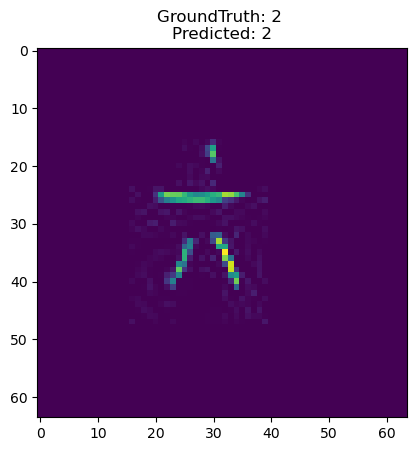

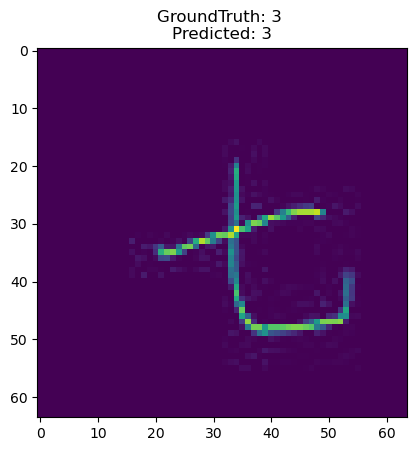

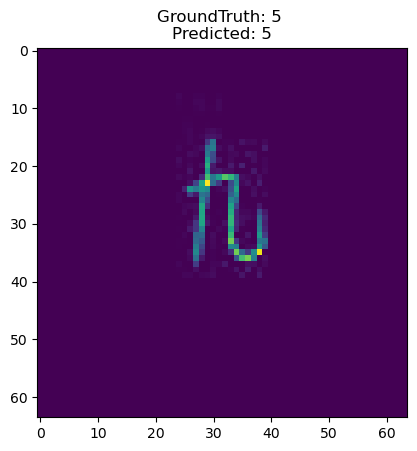

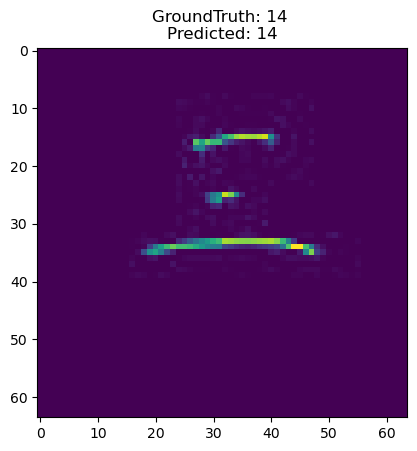

In [84]:
def imshow(img, title=None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Visualize some of the predictions
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Print images with predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j] % len(classes)] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j] % len(classes)] for j in range(4)))

# Show images with predictions
for i in range(4):
    imshow(images[i], f'GroundTruth: {classes[labels[i] % len(classes)]} \nPredicted: {classes[predicted[i] % len(classes)]}')

---
### Questions
Answer the following questions in detail.

1. What is a Convolutional Neural Network (CNN)? Describe its key components and how they differ from those in a fully connected neural network.
Answer: CNN is the Neural Network that's mostly for image processing.  It has the following layer.
    1. Convolution Layer - the layer apply specific number of convolution filters to the image.  For each subregion, it would produce a single value to the output map.  It's activation function is ReLu for this example.
    2. Pooling Layer - Each Convolution Layer will have a pooling layers following it.  The pooling layer for this example is the same for both convolution layer.  It is used to reduce the complexity and to reduce overfitting.
    3. Fully connected layer - After several Convolution Layer and Pooling layer, it's time converge the information.  First, flatten the layers, having the input being numbers of previous neuron layer times kernal size, then use ReLu activation function.  We use two layers before converge into the last layer with the output as the choices/classifications so it would be a softer merging.

    It's different from a fully connected network in that it's neurons are sparsely connected to small numbers of nearby neuron where as fully connected network, each neuron is connected to every other neuron.  Plus, instead of having each neuron have it's own weight, all the neurons in the same kernal share the same weight.

2. Explain the purpose of the convolution operation in a CNN. How does the use of different filter sizes affect the feature maps?
Answer: The convolution layer is the layers that learns in CNN.  By applying kernals, it can identify features/interest points such as curves, edges and lines. It then use those features in provide classifications or object detections.  Smaller kernals will see small interest points such as curve, points, lines, where as large kernals will see large interest points such as whole abstract images.  However, it is computationally expensive and might miss small interest points. 

3. What is the purpose of a pooling layer in a CNN, and how does it contribute to the network’s performance?
Answer: The pooling layer is added to reduce computation complexity and reduce overfitting by progressively reduce the width and height of the input volumn.  It usually does this by max pooling which find the max value in a set kernal size and set the entire region to be that number and merge the layer size down.

4. Why are activation functions important in CNNs? Compare the use of ReLU (Rectified Linear Unit) with other activation functions.
Answer: Activation function is important because it introduce non-linearity into the which enable the neuro network to learn. ReLu is an important function because it's computational easy as it only pass on either 0 or x(input value). Other activation functions are more computational expensive.  However, the last layer in the fully connected layer cannot use ReLU as activation function since it will not be useful for identification or classification (finding probability of an outcome) because it's simplicity (0 or x), so softmax is usually used for this as it will show a probability of between 0 and 1 for each choice.  

5. Describe the process of training a CNN. What are some common challenges faced during training?
Answer: Process of Training CNN
    1. Initialize the model.
    2. Set all weights to 0, or randomized the weight at the beginning.
    3. Forward Propergation.
    4. Loss computation.
    5. BackPropergation.
    6. Weight updates using SGD with a learning rate of 0.01 and momentum of 0.9.
    7. Repeat step 3-6 for 11 times (epoch number)
    8. For every 2000 mini batches, take a look of the loss function to make sure it's still learning.

Common Challenges
    1. Overfitting for models
    2. GPU/CPU Hungry. 
    3. Vanishing/Exploding Gradients (Underfitting)
    4. Select the right architecture (ie. kernal size, number of neurons, pooling size, number of layers), and hyperparameters (which optimizer, epoch number, learning rate and momentum rate, batch sizes.)
    5. lack of understanding of how the model arrived at its conclusion.

6. What are some common evaluation metrics used to assess the performance of a CNN on a classification task?
Answer: Accuacy, Precision, Recall, F1 score, AUC, confusion matrix.  We use accuracy for this classification task. 
7. How does data augmentation help improve the performance of a CNN? Provide examples of common data augmentation techniques.
Answer: Data augmentation would improve the performance by diversifing and increase the data for training and testing.  
Commong data augmentation - Changing the brightness of image, rotate it, resize it, change prespective, shifting the image in different directions.


---
### Submission
Submit a link to your completed Jupyter Notebook (e.g., on GitHub (private) or Google Colab) with all the cells executed, and answers to the assessment questions included at the end of the notebook.